<a href="https://colab.research.google.com/github/ketkiambekar/masters-research-project/blob/main/LSTM_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd drive/MyDrive/KetkiAmbekar/Raw\ Data\ Files
%pwd
%ls

/content/drive/.shortcut-targets-by-id/1zDGtpS_EJdRSKz3jZptcq5k6f4jqXBwI/KetkiAmbekar/Raw Data Files
 covid_BK.xlsx                   NYC_housing_prices_dropped_na.csv
 covid_BX.xlsx                   NYC_Housing_prices_dropped_values.csv
 covid_MN.xlsx                   NYC_HP_LSTM.csv
 covid_QN.xlsx                  'nyc_pluto_20v7_csv(1).zip'
 covid_real_estate.csv           nyc_pluto_20v7_csv.zip
 covid_SI.xlsx                   nyc_real_estate_PLUTO_+_Final.csv
 nyc_dataset_final.xlsx          pluto_20v7.csv
 NYC_housing_prices_dropped_na   Temperatures/


In [4]:
#Import Libraries
import matplotlib.pyplot as plt
import pandas as pd
import math
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error


# fix random seed for reproducibility
np.random.seed(7)

In [5]:
# load the dataset
#df = pd.read_csv('NYC_HP_LSTM.csv', engine='python', index_col='sales_date', parse_dates=True )
df = pd.read_csv('NYC_HP_LSTM.csv', engine='python', parse_dates=True )
df


,Unnamed: 0,borough_BK,borough_BX,borough_MN,borough_QN,borough_SI,tot_area,covid_cases,sales_date,sales_price
0,0,1.0,0.0,0.0,0.0,0.0,66638.0,1608,2020-08-31,5585336
1,1,1.0,0.0,0.0,0.0,0.0,8300.0,1608,2020-08-31,1643000
2,2,1.0,0.0,0.0,0.0,0.0,7488.0,1608,2020-08-31,1200000
3,3,1.0,0.0,0.0,0.0,0.0,6429.0,1608,2020-08-31,735000
4,4,1.0,0.0,0.0,0.0,0.0,7000.0,1608,2020-08-31,775000
...,...,...,...,...,...,...,...,...,...,...
76837,76837,0.0,0.0,0.0,0.0,1.0,5264.0,0,2018-01-02,680000
76838,76838,0.0,0.0,0.0,0.0,1.0,10268.0,0,2018-01-02,400000
76839,76839,0.0,0.0,0.0,0.0,1.0,4901.0,0,2018-01-02,565000
76840,76840,0.0,0.0,0.0,0.0,1.0,6525.0,0,2018-01-02,499500


In [6]:
df.drop(columns=['Unnamed: 0'], inplace=True)
df.head()

,borough_BK,borough_BX,borough_MN,borough_QN,borough_SI,tot_area,covid_cases,sales_date,sales_price
0,1.0,0.0,0.0,0.0,0.0,66638.0,1608,2020-08-31,5585336
1,1.0,0.0,0.0,0.0,0.0,8300.0,1608,2020-08-31,1643000
2,1.0,0.0,0.0,0.0,0.0,7488.0,1608,2020-08-31,1200000
3,1.0,0.0,0.0,0.0,0.0,6429.0,1608,2020-08-31,735000
4,1.0,0.0,0.0,0.0,0.0,7000.0,1608,2020-08-31,775000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76842 entries, 0 to 76841
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   borough_BK   76842 non-null  float64
 1   borough_BX   76842 non-null  float64
 2   borough_MN   76842 non-null  float64
 3   borough_QN   76842 non-null  float64
 4   borough_SI   76842 non-null  float64
 5   tot_area     76842 non-null  float64
 6   covid_cases  76842 non-null  int64  
 7   sales_date   76842 non-null  object 
 8   sales_price  76842 non-null  int64  
dtypes: float64(6), int64(2), object(1)
memory usage: 5.3+ MB


In [9]:
df['covid_cases']=df.covid_cases.astype('float64')
df['sales_price']=df.sales_price.astype('float64')
df['per_sqft_rate']=df['sales_price']/df['tot_area']

In [10]:
df.head()

,borough_BK,borough_BX,borough_MN,borough_QN,borough_SI,tot_area,covid_cases,sales_date,sales_price,per_sqft_rate
0,1.0,0.0,0.0,0.0,0.0,66638.0,1608.0,2020-08-31,5585336.0,83.816081
1,1.0,0.0,0.0,0.0,0.0,8300.0,1608.0,2020-08-31,1643000.0,197.951807
2,1.0,0.0,0.0,0.0,0.0,7488.0,1608.0,2020-08-31,1200000.0,160.256410
3,1.0,0.0,0.0,0.0,0.0,6429.0,1608.0,2020-08-31,735000.0,114.325712
4,1.0,0.0,0.0,0.0,0.0,7000.0,1608.0,2020-08-31,775000.0,110.714286


In [11]:
#We need to separate boroughs Let's first create a model for Brooklyn only

df_BK = df[df['borough_BK']==1]
df_BK = df[['tot_area', 'covid_cases', 'sales_date','sales_price','per_sqft_rate' ]]
df_BK

,tot_area,covid_cases,sales_date,sales_price,per_sqft_rate
0,66638.0,1608.0,2020-08-31,5585336.0,83.816081
1,8300.0,1608.0,2020-08-31,1643000.0,197.951807
2,7488.0,1608.0,2020-08-31,1200000.0,160.256410
3,6429.0,1608.0,2020-08-31,735000.0,114.325712
4,7000.0,1608.0,2020-08-31,775000.0,110.714286
...,...,...,...,...,...
76837,5264.0,0.0,2018-01-02,680000.0,129.179331
76838,10268.0,0.0,2018-01-02,400000.0,38.955980
76839,4901.0,0.0,2018-01-02,565000.0,115.282595
76840,6525.0,0.0,2018-01-02,499500.0,76.551724


In [12]:
sales_date = df['sales_date']

In [13]:
#We ensure, one datapoint per date. 
#We therefore, groupby sales_date column and aggregate over per_sqft_rate column on it's mean andchoose max number of covid_cases.
df_BK=df_BK.groupby(["sales_date"]).agg({'per_sqft_rate':'mean', 'covid_cases':'max'})
df_BK

,per_sqft_rate,covid_cases
sales_date,,
2018-01-01,29.068164,0.0
2018-01-02,112.733805,0.0
2018-01-03,78.229029,0.0
2018-01-04,87.236638,0.0
2018-01-05,77.624732,0.0
...,...,...
2020-08-26,153.116965,1754.0
2020-08-27,131.620605,1754.0
2020-08-28,128.667341,1754.0


In [14]:
df_BK.describe()

,per_sqft_rate,covid_cases
count,827.000000,827.000000
mean,112.915610,2006.338573
std,53.502946,6528.535324
min,0.064506,0.000000
25%,84.976315,0.000000
50%,116.610502,0.000000
75%,134.819387,0.000000
max,1049.128099,34019.000000


In [15]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
print(df_BK.shape)
scaler = StandardScaler()
scaler = scaler.fit(df_BK)
df_scaled = scaler.transform(df_BK)
df_scaled

(827, 2)


array([[-1.56810405, -0.3075043 ],
       [-0.0034001 , -0.3075043 ],
       [-0.64870392, -0.3075043 ],
       ...,
       [ 0.29458683, -0.03867503],
       [-1.19539502, -0.03867503],
       [ 0.08882048, -0.03867503]])

In [16]:
df_scaled.shape

(827, 2)

In [17]:
import numpy as np
df_BK['scaled_per_sqft_rate']= df_scaled[:,0]
df_BK['scaled_covid_cases']= df_scaled[:,1]
df_BK.head()

,per_sqft_rate,covid_cases,scaled_per_sqft_rate,scaled_covid_cases
sales_date,,,,
2018-01-01,29.068164,0.0,-1.568104,-0.307504
2018-01-02,112.733805,0.0,-0.003400,-0.307504
2018-01-03,78.229029,0.0,-0.648704,-0.307504
2018-01-04,87.236638,0.0,-0.480245,-0.307504
2018-01-05,77.624732,0.0,-0.660005,-0.307504


In [18]:
df_BK.tail(10)

,per_sqft_rate,covid_cases,scaled_per_sqft_rate,scaled_covid_cases
sales_date,,,,
2020-08-19,131.773825,1754.0,0.352684,-0.038675
2020-08-20,133.068943,1754.0,0.376905,-0.038675
2020-08-21,133.975795,1754.0,0.393865,-0.038675
2020-08-24,144.783767,1754.0,0.595994,-0.038675
2020-08-25,128.278371,1754.0,0.287312,-0.038675
2020-08-26,153.116965,1754.0,0.751841,-0.038675
2020-08-27,131.620605,1754.0,0.349818,-0.038675
2020-08-28,128.667341,1754.0,0.294587,-0.038675
2020-08-29,48.997135,1754.0,-1.195395,-0.038675


In [ ]:
# #Handling Missing Values
# import datetime
# def fill_in_missing_dates(df, date_col_name = 'sales_date',date_order = 'asc', fill_method = 'ffill', start_date ='2018-01-01'):

#     #df.set_index(date_col_name,drop=True,inplace=True)
#     df.index = pd.DatetimeIndex(df.index)
#     start=pd.to_datetime("2018-01-01")
#     end =pd.to_datetime('2020-08-31')
#     #d2 = (d - pd.to_datetime(start_date)).days
#     #print(d,d2)
#     idx = pd.date_range(start=start, end=end, freq = "D")
#     df = df.reindex(idx,method=fill_method)
#     df[date_col_name] = pd.DatetimeIndex(df.index)

#     return df

# df_BK=fill_in_missing_dates(df_BK )
# df_BK

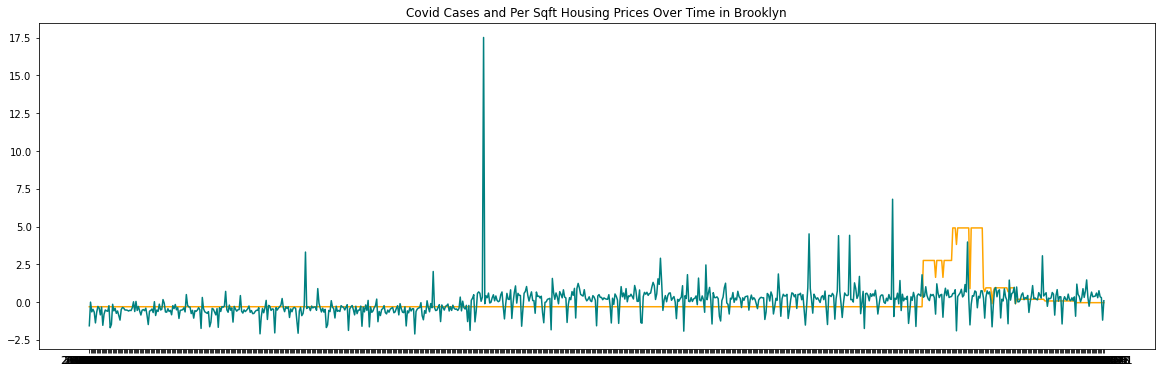

In [19]:
#Plotting Normalized Prices and Covid Cases
plt.figure(figsize=(20,6))
plt.title("Covid Cases and Per Sqft Housing Prices Over Time in Brooklyn")
plt.plot(df_BK['scaled_covid_cases'], linestyle='solid', color='orange')
plt.plot(df_BK['scaled_per_sqft_rate'], linestyle='solid', color='teal')
plt.grid(False)
#sns.lineplot(data=trends.drop(['sales_price', 'covid_cases'], axis=1));

In [20]:
#Separate dates for future plotting
train_dates = pd.to_datetime(df_BK.index)
train_dates

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-07', '2018-01-08', '2018-01-09',
               '2018-01-10', '2018-01-11',
               ...
               '2020-08-19', '2020-08-20', '2020-08-21', '2020-08-24',
               '2020-08-25', '2020-08-26', '2020-08-27', '2020-08-28',
               '2020-08-29', '2020-08-31'],
              dtype='datetime64[ns]', name='sales_date', length=827, freq=None)

In [21]:
trainX = []
trainY = []

n_future = 7   # Number of days we want to predict into the future
n_past = 14     # Number of past days we want to use to predict the future


#Creating sequential window trainX for training. 
#Sample trainX window : [0.1 0.2 0.3 0.5 0.4 0.1 ]
for i in range(n_past, len(df_scaled) - n_future +1):
    trainX.append(df_scaled[i - n_past:i, 0:df_scaled.shape[1]])
    trainY.append(df_scaled[i + n_future - 1:i + n_future, 0])


In [71]:
trainX=trainX[:800]
trainY=trainY[:800]

In [22]:
df_scaled.shape

(827, 2)

In [23]:
print(trainX[0])

[[-1.56810405 -0.3075043 ]
 [-0.0034001  -0.3075043 ]
 [-0.64870392 -0.3075043 ]
 [-0.4802448  -0.3075043 ]
 [-0.66000542 -0.3075043 ]
 [-1.37834975 -0.3075043 ]
 [-0.68485516 -0.3075043 ]
 [-0.28925468 -0.3075043 ]
 [-0.38884578 -0.3075043 ]
 [-0.8474091  -0.3075043 ]
 [-0.32847487 -0.3075043 ]
 [-1.53769755 -0.3075043 ]
 [-0.80579558 -0.3075043 ]
 [-0.52169578 -0.3075043 ]]


In [24]:
trainX, trainY = np.array(trainX), np.array(trainY)

In [25]:
print(trainX.shape)

(807, 14, 2)


In [26]:
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))


trainX shape == (807, 14, 2).
trainY shape == (807, 1).


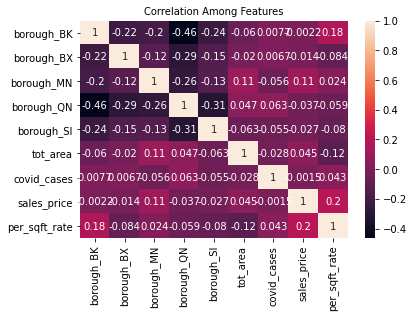

<Figure size 1080x1080 with 0 Axes>

In [27]:
# Correlations among columns
import seaborn as sns
sns.heatmap(df.corr(),annot=True);
plt.title('Correlation Among Features', size=10);
plt.figure(figsize=(15,15));
plt.show();

In [28]:
# define LSTM model
model=None
model = Sequential()
model.add(LSTM(32, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 14, 32)            4480      
_________________________________________________________________
lstm_1 (LSTM)                (None, 14, 32)            8320      
_________________________________________________________________
dropout (Dropout)            (None, 14, 32)            0         
_________________________________________________________________
dense (Dense)                (None, 14, 1)             33        
Total params: 12,833
Trainable params: 12,833
Non-trainable params: 0
_________________________________________________________________


Train...
Epoch 1/10
9/9 [==============================] - 3s 93ms/step - loss: 1.3702 - val_loss: 0.9727
Epoch 2/10
9/9 [==============================] - 0s 19ms/step - loss: 0.8314 - val_loss: 0.9776
Epoch 3/10
9/9 [==============================] - 0s 21ms/step - loss: 0.8748 - val_loss: 0.9815
Epoch 4/10
9/9 [==============================] - 0s 22ms/step - loss: 0.5946 - val_loss: 0.9806
Epoch 5/10
9/9 [==============================] - 0s 22ms/step - loss: 1.0851 - val_loss: 0.9423
Epoch 6/10
9/9 [==============================] - 0s 21ms/step - loss: 0.8049 - val_loss: 0.9277
Epoch 7/10
9/9 [==============================] - 0s 22ms/step - loss: 0.8933 - val_loss: 0.9301
Epoch 8/10
9/9 [==============================] - 0s 22ms/step - loss: 0.7349 - val_loss: 0.9404
Epoch 9/10
9/9 [==============================] - 0s 21ms/step - loss: 0.7784 - val_loss: 0.9442
Epoch 10/10
9/9 [==============================] - 0s 22ms/step - loss: 1.0326 - val_loss: 0.9400


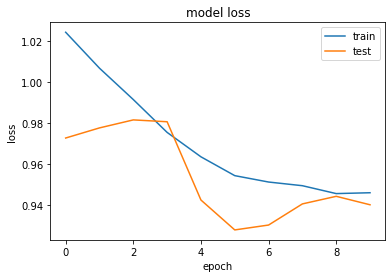

In [29]:
print('Train...')

#fit

history = model.fit(trainX, trainY, epochs=10, batch_size=70, validation_split=0.3, verbose=1)
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# # make a prediction
# yhat = model.predict(Test_X)
# test_X = test_X.reshape((Test_X.shape[0], 7))
# # invert scaling for forecast
# inv_yhat = np.concatenate((yhat, test_X[:, -6:]), axis=1)
# inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat = inv_yhat[:,0]
# # invert scaling for actual
# test_y = test_y.reshape((len(test_y), 1))
# inv_y = np.concatenate((test_y, test_X[:, -6:]), axis=1)
# inv_y = scaler.inverse_transform(inv_y)
# inv_y = inv_y[:,0]
# # calculate RMSE
# rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
# print('Test RMSE: %.3f' % rmse)

In [ ]:
print(len(history.history['loss']))

10


In [31]:
#Forecasting...
#Start with the last day in training date and predict future...
n_future=90 #Redefining n_future to extend prediction dates beyond original n_future dates...
forecast_period_dates = pd.date_range(list(train_dates)[-1], periods=n_future, freq='1d').tolist()
print(type(forecast_period_dates[0]))

forecast = model.predict(trainX[-n_future:]) #forecast 
#print(forecast)
#Perform inverse transformation to rescale back to original range
#Since we used 2 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 2 times and discard them after inverse transform
forecast_copies = np.repeat(forecast, 2, axis=-1)
print(forecast_copies.shape)


#Inverse Transform the forecast using previous scaler
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]


# Convert timestamp to date
forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'sales_date':np.array(forecast_dates), 'per_sqft_rate':y_pred_future[0]})
df_forecast['sales_date']=pd.to_datetime(df_forecast['sales_date'])
original = pd.DataFrame()
original['per_sqft_rate'] = df_BK['per_sqft_rate']
original['sales_date']=sales_date
original['sales_date']=pd.to_datetime(original['sales_date'])
original=original[0:-1]
original = original[original['sales_date'] >= '2020-8-1']


plt.figure(figsize=(15,10))
sns.lineplot(original['sales_date'], original['per_sqft_rate']);
sns.lineplot(df_forecast['sales_date'], df_forecast['per_sqft_rate']);


<class 'pandas._libs.tslibs.timestamps.Timestamp'>
(90, 14, 2)


ValueError: ignored